# 2. Graphs in 3D
**Team 9**

In [ ]:
!pip install torch torch_geometric matplotlib open3d pytorch_lightning plyfile

In [ ]:
# Standard Python Libraries
import os
import random
import statistics

# Data Manipulation and Visualization Libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from plyfile import PlyData

# PyTorch Core Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, random_split

# PyTorch Lightning
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

# PyTorch Geometric Libraries
import torch_geometric.transforms as T
from torch_geometric.data import Dataset, DataLoader as GDataLoader
from torch_geometric.datasets import ModelNet
from torch_geometric.nn import GCNConv, global_max_pool

# Other Libraries
import open3d as o3d
from sklearn.metrics import accuracy_score
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [ ]:
# Set a fixed seed for random number generators to ensure reproducibility
DATA_PERTURB_SEEDS = [42]
random.seed(42)

# Check and set the device for torch operations
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Plotting Function

In [ ]:
def plot_combined_results(metrics_per_dataset, plot_name):
    """
    Plot and save combined results of training and validation loss and accuracy
    for different datasets across multiple seeds.

    Args:
    metrics_per_dataset (dict): A dictionary containing metrics for each dataset.
    plot_name (str): Name of the file to save plots.
    """
    num_seeds = len(metrics_per_dataset[list(metrics_per_dataset.keys())[0]])

    for seed_idx in range(num_seeds):
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))

        for dataset_key, all_metrics in metrics_per_dataset.items():
            metrics = all_metrics[seed_idx]  # Metrics for the current seed

            # Plotting training and validation loss
            epochs_train = range(1, len(metrics["train_loss"]) + 1)
            epochs_val = range(1, len(metrics["val_loss"]) + 1)
            axes[0].plot(epochs_train, metrics["train_loss"], label=f'Train Loss - {dataset_key} points')
            axes[0].plot(epochs_val, metrics["val_loss"], '--', label=f'Val Loss - {dataset_key} points')

            # Plotting training and validation accuracy
            epochs_train_acc = range(1, len(metrics["train_accuracy"]) + 1)
            epochs_val_acc = range(1, len(metrics["val_accuracy"]) + 1)
            axes[1].plot(epochs_train_acc, metrics["train_accuracy"], label=f'Train Acc - {dataset_key} points')
            axes[1].plot(epochs_val_acc, metrics["val_accuracy"], '--', label=f'Val Acc - {dataset_key} points')

        # Setting labels, titles, and legends
        axes[0].set_xlabel('Epochs')
        axes[0].set_ylabel('Loss')
        axes[0].set_title(f'Training and Validation Loss - Seed {seed_idx + 1}')
        axes[0].legend()

        axes[1].set_xlabel('Epochs')
        axes[1].set_ylabel('Accuracy')
        axes[1].set_title(f'Training and Validation Accuracy - Seed {seed_idx + 1}')
        axes[1].legend()

        plt.tight_layout()
        plt.savefig(f"{plot_name}_seed_{seed_idx + 1}.png")

## 2.1 Voxel Format

### 2.1.1 Data exploration

In [ ]:
# Load and explore the ModelNet10 dataset
dataset = ModelNet(root='./ModelNet10', name='10')
print(f"Dataset size: {len(dataset)}")
print(f"Number of classes: {dataset.num_classes}")
print(f"Example data point: {dataset[0]}")

Extracting ModelNet10/ModelNet10.zip
Processing...
Done!


Dataset size: 3991
Number of classes: 10
Example data point: Data(pos=[3456, 3], face=[3, 5456], y=[1])


Dataset size: 3991
Number of classes: 10
Average number of points: 9897.486594838387
Range of point counts: 100 to 502603
Missing or malformed data points: 0


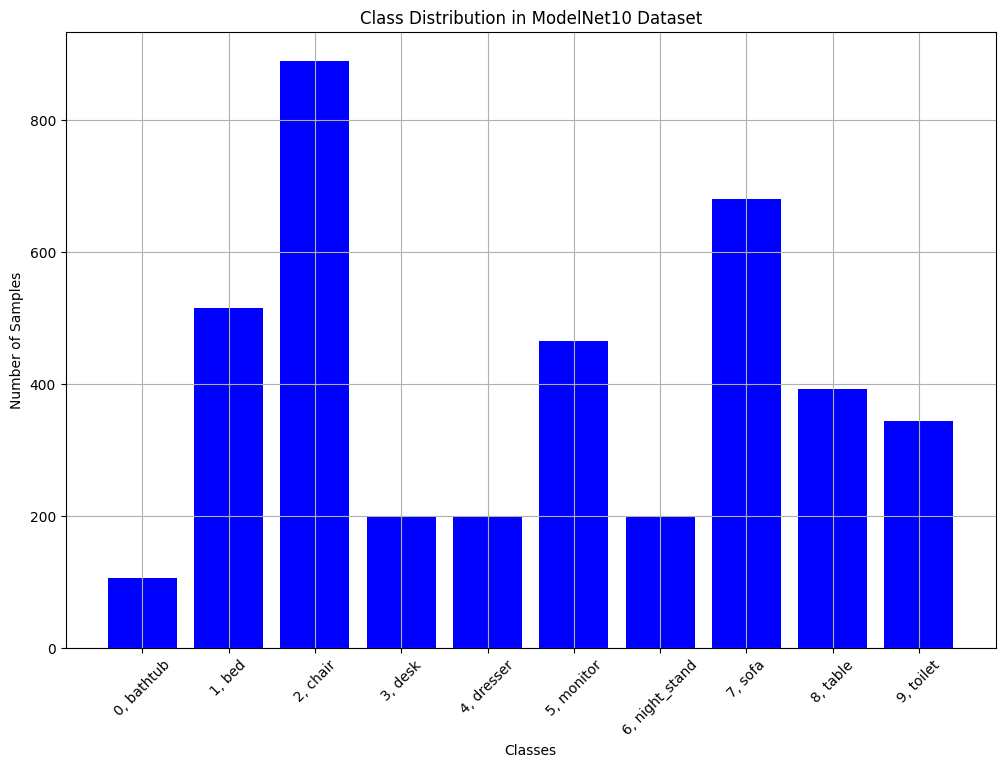

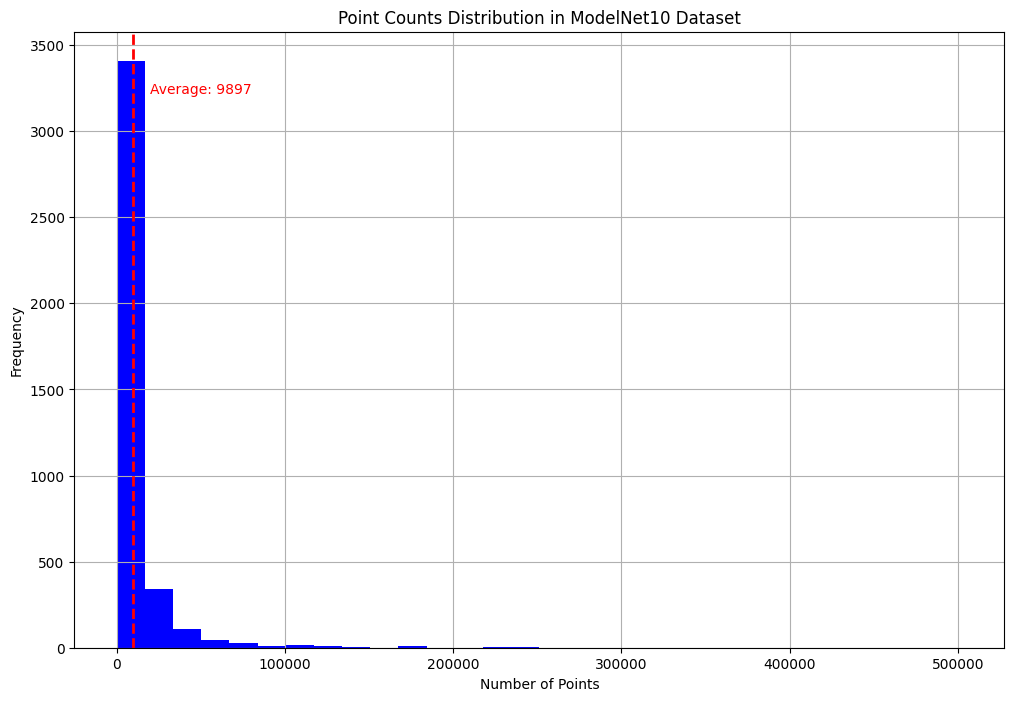

In [ ]:
# Calculate dataset statistics
num_classes = dataset.num_classes
class_distribution = np.zeros(num_classes)
point_counts = []
class_names = dataset.raw_file_names

for data in dataset:
    class_distribution[data.y] += 1
    point_counts.append(data.pos.shape[0])

average_points = np.mean(point_counts)
min_points = np.min(point_counts)
max_points = np.max(point_counts)
missing_data = sum([1 for data in dataset if data is None or data.pos is None])

# Create and save histograms for class distribution and point counts
plt.figure(figsize=(12, 8))
class_labels = [f"{i}, {name}" for i, name in enumerate(class_names)]
plt.bar(class_labels, class_distribution, color='blue')
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in ModelNet10 Dataset')
plt.xticks(rotation=45)
plt.grid(True)
plt.savefig('histo_classes.png')

plt.figure(figsize=(12, 8))
plt.hist(point_counts, bins=30, color='blue')
plt.axvline(average_points, color='red', linestyle='dashed', linewidth=2)
plt.xlabel('Number of Points')
plt.ylabel('Frequency')
plt.title('Point Counts Distribution in ModelNet10 Dataset')
plt.text(average_points+10000, plt.ylim()[1]*0.9, f'Average: {average_points:.0f}', color='red')
plt.grid(True)
plt.savefig('histo_points.png')

# Print additional dataset statistics
print(f"Dataset size: {len(dataset)}")
print(f"Number of classes: {num_classes}")
print(f"Average number of points: {average_points}")
print(f"Range of point counts: {min_points} to {max_points}")
print(f"Missing or malformed data points: {missing_data}")

### Random Baseline

In [ ]:
def random_baseline(dataset, num_classes):
    """
    Calculate the baseline accuracy by randomly guessing the class.

    Args:
    dataset (torch_geometric.data.Dataset): The dataset to evaluate.
    num_classes (int): The number of classes in the dataset.

    Returns:
    float: The calculated accuracy.
    """
    correct = 0
    for data in dataset:
        pred = random.randint(0, num_classes - 1)
        correct += pred == data.y
    return correct / len(dataset)

# Store accuracies from each run
accuracies = []

for _ in range(3):
    accuracy = random_baseline(dataset, num_classes)
    # Convert Tensor to a Python float
    accuracies.append(accuracy.item() if hasattr(accuracy, 'item') else accuracy)

# Calculate average accuracy
avg_accuracy = sum(accuracies) / len(accuracies)

# Calculate standard deviation
std_dev = statistics.stdev(accuracies)

print("Average Accuracy:", avg_accuracy)
print("Standard Deviation:", std_dev)


Average Accuracy: 0.09863860160112381
Standard Deviation: 0.007272107861141521


### 2.1.2 Voxelization


In [ ]:
def voxelize(pcd, voxel_size=(32, 32, 32)):
    """
    Convert a point cloud to a voxel grid.

    Args:
    pcd (o3d.geometry.PointCloud): The point cloud to voxelize.
    voxel_size (tuple): The size of each voxel as (x, y, z).

    Returns:
    o3d.geometry.VoxelGrid: The voxelized point cloud.
    """
    # Calculate appropriate voxel size
    bounding_box = pcd.get_axis_aligned_bounding_box()
    voxel_dim = np.divide(bounding_box.get_extent(), voxel_size)

    # Voxelization
    voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(pcd, min(voxel_dim))

    return voxel_grid

def visualize_data(geometry):
    """
    Visualize a geometric data structure using Open3D.

    Args:
    geometry (o3d.geometry.Geometry): The geometry to visualize.
    """
    o3d.visualization.draw_geometries([geometry])

# Process the first data point for visualization
data_point = dataset[0]
points = np.array(data_point.pos)  # Assuming `pos` attribute has the point data
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)

print('Original Point Cloud')
visualize_data(pcd)

voxel_grid = voxelize(pcd, voxel_size=(1,1,1))
print('Voxelized Point Cloud')
visualize_data(voxel_grid)

voxel_grid = voxelize(pcd, voxel_size=(10,10,10))
print('Voxelized Point Cloud')
visualize_data(voxel_grid)

voxel_grid = voxelize(pcd, voxel_size=(100,100,100))
print('Voxelized Point Cloud')
visualize_data(voxel_grid)


NameError: ignored

### 2.1.3 3D CNN

#### Helper methods and Model Declaration
Methods to construct voxelisation Grid at different sizes

In [ ]:
def voxelize_grid(data, voxel_size=(32, 32, 32)):
    # Convert to Open3D point cloud format
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(np.array(data.pos))

    # Calculate appropriate voxel size based on the bounding box
    bounding_box = pcd.get_axis_aligned_bounding_box()
    max_extent = max(bounding_box.get_extent())
    voxel_size = max_extent / max(voxel_size)

    # Create a voxel grid
    voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(pcd, voxel_size)

    return voxel_grid

def create_binary_voxel_grid(voxelized_data, size):
    voxel_grid_indices = torch.tensor([voxel.grid_index for voxel in voxelized_data.get_voxels()])
    # Create a grid tensor using advanced indexing
    grid = torch.zeros(len(voxel_grid_indices), 1, size+1, size+1, size+1)
    grid[
        torch.arange(len(voxel_grid_indices)),  # indices along the batch dimension
        0,  # channel dimension
        voxel_grid_indices[:, 0],  # indices along the first spatial dimension
        voxel_grid_indices[:, 1],  # indices along the second spatial dimension
        voxel_grid_indices[:, 2],  # indices along the third spatial dimension
    ] = 1
    return grid

class Simple3DCNNForObjectClassification(nn.Module):
    def __init__(self, num_classes):
        super(Simple3DCNNForObjectClassification, self).__init__()
        self.conv1 = nn.Conv3d(1, 32, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv3d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 64 * 4 * 2, 128)
        self.fc2 = nn.Linear(128, num_classes)  # Output layer without activation
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = x.sum(dim=0) # Reduce along spatial dimensions
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x.squeeze()  # Remove the batch dimension


Note, due to the complexity of the CNN and memory constraints, we have to sample smaller training and test batches. We train on 100 batches, validate on 40 batches and test on another 40

#### CNN Voxel Size 5

In [ ]:
torch.manual_seed(42)
train_size = 100
val_size = 40
test_size = 40

def transform(data,vox_size = 5):
    voxelgridobj = voxelize_grid(data, voxel_size=(vox_size, vox_size, vox_size))
    grid = create_binary_voxel_grid(voxelgridobj,vox_size)
    return grid, data.y

dataset_transformed = ModelNet(root='...', name='10', transform=transform)
dataset_transformed = dataset_transformed[:train_size+val_size+test_size]

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset_transformed, [train_size, val_size, test_size])

class Simple3DCNNForObjectClassification(nn.Module):
    def __init__(self, num_classes):
        super(Simple3DCNNForObjectClassification, self).__init__()
        self.conv1 = nn.Conv3d(1, 32, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv3d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64, 128)
        self.fc2 = nn.Linear(128, num_classes)  # Output layer without activation
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = x.sum(dim=0)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x.squeeze()


# Create DataLoaders for batching
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


model = Simple3DCNNForObjectClassification(10)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


num_epochs = 10
loss_fn = nn.CrossEntropyLoss()

train_losses = []
test_losses = []

for epoch in range(num_epochs):
    total_loss = 0
    total = 0
    correct = 0
    for idx, batch in enumerate(train_loader):
        # Move batch to device
        # Forward pass
        grid, y = batch
        outputs = model(grid[0])
        loss = loss_fn(outputs.view(1,-1),y[0])
        # Backward and optimize
        total_loss += loss

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    train_losses.append(total_loss.item()/len(train_loader))

    # Test the model
    with torch.no_grad():
        correct = 0
        total = 0
        total_test_loss = 0
        for idx, batch in enumerate(val_loader):
            grid, y = batch
            outputs = model(grid[0])
            loss = loss_fn(outputs.view(1,-1),y[0])
            total_test_loss += loss
        test_losses.append(total_loss.item() / len(train_loader))
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {total_loss / 10}, Val Loss: {total_test_loss / 5}')

#getting Test Accuracy
correct = 0
total = 0
with torch.no_grad():
    for idx, batch in enumerate(test_loader):
        grid, y = batch
        outputs = model(grid[0])
        _, predicted = torch.max(outputs.data, 0)
        total += 1
        correct += (predicted == y.item()).sum().item()

print("Test Accuracy: ", correct/total)


Epoch [1/10], Train Loss: 24.967365264892578, Val Loss: 11.281717300415039
Epoch [2/10], Train Loss: 13.872157096862793, Val Loss: 8.071081161499023
Epoch [3/10], Train Loss: 9.757760047912598, Val Loss: 6.822002410888672
Epoch [4/10], Train Loss: 8.141616821289062, Val Loss: 5.869399547576904
Epoch [5/10], Train Loss: 7.074538230895996, Val Loss: 5.673148155212402
Epoch [6/10], Train Loss: 7.034765720367432, Val Loss: 5.1970295906066895
Epoch [7/10], Train Loss: 6.406093597412109, Val Loss: 5.44114351272583
Epoch [8/10], Train Loss: 6.723552703857422, Val Loss: 4.934675216674805
Epoch [9/10], Train Loss: 6.1469526290893555, Val Loss: 5.0559282302856445
Epoch [10/10], Train Loss: 6.411136627197266, Val Loss: 4.721170902252197
Test Accuracy:  0.65


#### CNN Voxel Size 10

In [ ]:
train_size = 100
val_size = 40
test_size = 40

def transform(data,vox_size = 10):
    voxelgridobj = voxelize_grid(data, voxel_size=(vox_size, vox_size, vox_size))
    grid = create_binary_voxel_grid(voxelgridobj,vox_size)
    return grid, data.y
dataset_transformed = ModelNet(root='...', name='10', transform=transform)
dataset_transformed = dataset_transformed[:train_size+val_size+test_size]

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset_transformed, [train_size, val_size, test_size])

class Simple3DCNNForObjectClassification(nn.Module):
    def __init__(self, num_classes):
        super(Simple3DCNNForObjectClassification, self).__init__()
        self.conv1 = nn.Conv3d(1, 32, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv3d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(512, 128)
        self.fc2 = nn.Linear(128, num_classes)  # Output layer without activation
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = x.sum(dim=0)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x.squeeze()

# Create DataLoaders for batching
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


model = Simple3DCNNForObjectClassification(10)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


num_epochs = 10
loss_fn = nn.CrossEntropyLoss()

train_losses = []
test_losses = []

for epoch in range(num_epochs):
    total_loss = 0
    total = 0
    correct = 0
    for idx, batch in enumerate(train_loader):
        # Move batch to device
        # Forward pass
        grid, y = batch
        outputs = model(grid[0])
        loss = loss_fn(outputs.view(1,-1),y[0])
        # Backward and optimize
        total_loss += loss

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    train_losses.append(total_loss.item() / len(train_loader))

    # Test the model
    with torch.no_grad():
        correct = 0
        total = 0
        total_test_loss = 0
        for idx, batch in enumerate(val_loader):
            grid, y = batch
            outputs = model(grid[0])
            loss = loss_fn(outputs.view(1,-1),y[0])
            total_test_loss += loss
        test_losses.append(total_loss.item() / len(train_loader))
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {total_loss / 10}, Val Loss: {total_test_loss / 5}')

#getting Test Accuracy
correct = 0
total = 0
with torch.no_grad():
    for idx, batch in enumerate(test_loader):
        grid, y = batch
        outputs = model(grid[0])
        _, predicted = torch.max(outputs.data, 0)
        total += 1
        correct += (predicted == y.item()).sum().item()

print("Test Accuracy: ", correct/total)


Epoch [1/10], Train Loss: 29.1972713470459, Val Loss: 8.766965866088867
Epoch [2/10], Train Loss: 11.485588073730469, Val Loss: 19.454381942749023
Epoch [3/10], Train Loss: 18.51063346862793, Val Loss: 9.714144706726074
Epoch [4/10], Train Loss: 9.776789665222168, Val Loss: 10.460235595703125
Epoch [5/10], Train Loss: 14.990903854370117, Val Loss: 6.7751007080078125
Epoch [6/10], Train Loss: 9.307188034057617, Val Loss: 7.72383975982666
Epoch [7/10], Train Loss: 7.874691963195801, Val Loss: 10.122331619262695
Epoch [8/10], Train Loss: 9.815399169921875, Val Loss: 8.373642921447754
Epoch [9/10], Train Loss: 8.33749008178711, Val Loss: 5.401880741119385
Epoch [10/10], Train Loss: 6.340663433074951, Val Loss: 6.3865132331848145
Test Accuracy:  0.5


#### CNN Voxel Size 15

In [ ]:
train_size = 100
val_size = 40
test_size = 40


def transform(data,vox_size = 15):
    voxelgridobj = voxelize_grid(data, voxel_size=(vox_size, vox_size, vox_size))
    grid = create_binary_voxel_grid(voxelgridobj,vox_size)
    return grid, data.y
dataset_transformed = ModelNet(root='...', name='10', transform=transform)
dataset_transformed = dataset_transformed[:train_size+val_size+test_size]

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset_transformed, [train_size, val_size, test_size])

class Simple3DCNNForObjectClassification(nn.Module):
    def __init__(self, num_classes):
        super(Simple3DCNNForObjectClassification, self).__init__()
        self.conv1 = nn.Conv3d(1, 32, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv3d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(4096, 128)
        self.fc2 = nn.Linear(128, num_classes)  # Output layer without activation
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = x.sum(dim=0)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x.squeeze()

# Create DataLoaders for batching
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


model = Simple3DCNNForObjectClassification(10)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


num_epochs = 10
loss_fn = nn.CrossEntropyLoss()

train_losses = []
test_losses = []

for epoch in range(num_epochs):
    total_loss = 0
    total = 0
    correct = 0
    for idx, batch in enumerate(train_loader):
        # Move batch to device
        # Forward pass
        grid, y = batch
        outputs = model(grid[0])
        loss = loss_fn(outputs.view(1,-1),y[0])
        # Backward and optimize
        total_loss += loss

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    train_losses.append(total_loss.item() / len(train_loader))

    # Test the model
    with torch.no_grad():
        correct = 0
        total = 0
        total_test_loss = 0
        for idx, batch in enumerate(val_loader):
            grid, y = batch
            outputs = model(grid[0])
            loss = loss_fn(outputs.view(1,-1),y[0])
            total_test_loss += loss
        test_losses.append(total_loss.item() / len(train_loader))
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {total_loss / 10}, Val Loss: {total_test_loss / 5}')

#getting Test Accuracy
correct = 0
total = 0
with torch.no_grad():
    for idx, batch in enumerate(test_loader):
        grid, y = batch
        outputs = model(grid[0])
        _, predicted = torch.max(outputs.data, 0)
        total += 1
        correct += (predicted == y.item()).sum().item()

print("Test Accuracy: ", correct/total)


Epoch [1/10], Train Loss: 23.70794105529785, Val Loss: 42.296817779541016
Epoch [2/10], Train Loss: 73.17851257324219, Val Loss: 6.057927131652832
Epoch [3/10], Train Loss: 7.348559379577637, Val Loss: 20.036083221435547
Epoch [4/10], Train Loss: 23.04290771484375, Val Loss: 6.461673736572266
Epoch [5/10], Train Loss: 7.752511501312256, Val Loss: 8.482370376586914
Epoch [6/10], Train Loss: 12.620863914489746, Val Loss: 7.795687198638916
Epoch [7/10], Train Loss: 10.824114799499512, Val Loss: 7.322915554046631
Epoch [8/10], Train Loss: 8.98216724395752, Val Loss: 8.386520385742188
Epoch [9/10], Train Loss: 9.519885063171387, Val Loss: 8.496373176574707
Epoch [10/10], Train Loss: 9.60870361328125, Val Loss: 8.143657684326172
Test Accuracy:  0.475


Although counterintuitive, the decreased accuracy with increased voxel size can be attributed to overly complicated networks. As the voxel size increases, so too do the number of parameters. As a result, training is more unstable (as evident by non-uniform behaviour of the loss in size 10 and 15) and less robust networks (lower test accuracy)

## 2.2 Point clouds

### 2.2.1 Point Cloud Format

In [ ]:
# Define the transform
transform_1024 = T.FixedPoints(1024)
transform_2048 = T.FixedPoints(2048)
transform_512 = T.FixedPoints(512)
transform_256 = T.FixedPoints(256)

# Apply the transform to the dataset
dataset_transformed_1024 = ModelNet(root='./ModelNet10_FixedPoints_1024', name='10', transform=transform_1024)
dataset_transformed_2048 = ModelNet(root='./ModelNet10_FixedPoints_2048', name='10', transform=transform_2048)
dataset_transformed_512 = ModelNet(root='./ModelNet10_FixedPoints_512', name='10', transform=transform_512)
dataset_transformed_256 = ModelNet(root='./ModelNet10_FixedPoints_256', name='10', transform=transform_256)

Processing...
Done!
Extracting ModelNet10_FixedPoints_256/ModelNet10.zip
Processing...
Done!


In [ ]:
def process_and_visualize(dataset):
    """
    Process and visualize the first data point of a given dataset.

    Args:
    dataset (torch_geometric.data.Dataset): The dataset to process and visualize.
    """
    data_point = dataset[0]
    points = np.array(data_point.pos)
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)

    print('Visualizing Point Cloud')
    visualize_data(pcd)

# Visualize each transformed dataset
print("Visualizing Dataset with 1024 Points")
process_and_visualize(dataset_transformed_1024)

print("Visualizing Dataset with 2048 Points")
process_and_visualize(dataset_transformed_2048)

print("Visualizing Dataset with 512 Points")
process_and_visualize(dataset_transformed_512)

print("Visualizing Dataset with 256 Points")
process_and_visualize(dataset_transformed_256)

Visualizing Dataset with 1024 Points
Visualizing Point Cloud
[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.
Visualizing Dataset with 2048 Points
Visualizing Point Cloud
[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.
Visualizing Dataset with 512 Points
Visualizing Point Cloud
[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.
Visualizing Dataset with 256 Points
Visualizing Point Cloud
[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


### 2.2.2 Coordinate baseline

In [ ]:
class PointCloudWrapper(pl.LightningModule):
    """
    A Pytorch Lightning Wrapper to train
    sequence models (classifiers/regressors)
    """

    def __init__(self, dataset, model, learning_rate=0.01, use_lr_scheduler=False, weight_decay=0.0001,
                 schedule_patience=20, use_node_attr=False, use_edge_attr=False) -> None:
        super().__init__()

        # Store the dataset and define loss
        self.data = dataset
        self.model = model
        self.loss = nn.CrossEntropyLoss()

        # Store hyperparameters
        self.use_node_attr = use_node_attr
        self.use_edge_attr = use_edge_attr
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.use_lr_scheduler = use_lr_scheduler
        self.patience = schedule_patience

        # Utility variables to track the training, validation, and test loss/accuracy
        self.train_loss = []
        self.val_loss = []
        self.train_proba = []
        self.train_labels = []
        self.val_proba = []
        self.val_labels = []
        self.test_loss = []
        self.test_proba = []
        self.test_labels = []
        self.epoch_train_loss = []
        self.epoch_train_accuracy = []
        self.epoch_val_loss = []
        self.epoch_val_accuracy = []
        self.epoch_test_loss = []
        self.epoch_test_accuracy = []

        self.save_hyperparameters(ignore=["model", "dataset"])


    def forward(self, data):
        """
        Forward pass of the model.
        """
        logits = self.model(data)  # Pass the whole data object
        return logits

    def compute_loss(self, logits, labels) -> torch.Tensor:
        """
        Loss computation, signal from the training nodes
        again for simplicity we consider all other nodes as validation nodes
        """
        # Task specific loss
        train_logits = logits
        train_labels = labels

        loss = self.loss(train_logits, train_labels)

        return loss

    def training_step(self, batch, batch_idx):
        """
        Define a single learning step
        """
        logits = self(batch)  # Pass the whole batch
        loss = self.compute_loss(logits, batch.y)  # Use batch.y for labels

        train_proba = F.softmax(logits, dim=-1).detach().cpu().numpy()
        train_labels = batch.y.detach().cpu().numpy()  # Corrected to batch.y

        self.train_loss.append(loss.detach().cpu().numpy())
        self.train_proba.append(train_proba)
        self.train_labels.append(train_labels)

        return loss

    def on_train_epoch_end(self) -> None:
        """
        At the end of an epoch we compute and log metrics
        """
        train_loss = np.mean(self.train_loss)
        self.log("train/loss", train_loss, prog_bar=True)

        train_proba = np.concatenate(self.train_proba)
        train_labels = np.concatenate(self.train_labels)
        train_acc = accuracy_score(train_labels, np.argmax(train_proba, axis=-1))
        self.log("train/accuracy", train_acc, prog_bar=False)

        self.epoch_train_loss.append(train_loss)
        self.epoch_train_accuracy.append(train_acc)

        self.train_loss.clear()
        self.train_proba.clear()
        self.train_labels.clear()

    def validation_step(self, batch, batch_idx):
        """
        Define a validation step
        """
        logits = self(batch)  # Pass the whole batch
        loss = self.compute_loss(logits, batch.y)  # Use batch.y for labels

        val_proba = F.softmax(logits, dim=-1).detach().cpu().numpy()
        val_labels = batch.y.detach().cpu().numpy()  # Corrected to batch.y

        self.val_loss.append(loss.detach().cpu().numpy())
        self.val_proba.append(val_proba)
        self.val_labels.append(val_labels)

    def on_validation_epoch_end(self) -> None:
        """
        Compute and log validation metrics, and visualize the hidden layers
        """
        val_loss = float(np.mean(self.val_loss))
        self.log("val/loss", val_loss, prog_bar=True)

        val_proba = np.concatenate(self.val_proba)
        val_labels = np.concatenate(self.val_labels)
        val_acc = accuracy_score(val_labels, np.argmax(val_proba, axis=-1))
        self.log("val/accuracy", val_acc, prog_bar=False)

        self.epoch_val_loss.append(val_loss)
        self.epoch_val_accuracy.append(val_acc)


        self.val_loss.clear()
        self.val_proba.clear()
        self.val_labels.clear()

    def configure_optimizers(self):
        """
        Configure optimizers.
        """
        optimizer = torch.optim.Adam(
            self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay
        )

        if self.use_lr_scheduler:
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.25, patience=self.patience, min_lr=0.0001)
            return {
                'optimizer': optimizer,
                'lr_scheduler': scheduler,
                'monitor': 'train/loss'
            }

        return optimizer

    def test_step(self, batch, batch_idx):
        """
        The method for testing each batch.
        """
        logits = self(batch)  # Get the model output for the batch
        loss = self.compute_loss(logits, batch.y)  # Compute the loss

        test_proba = F.softmax(logits, dim=-1).detach().cpu().numpy()
        test_labels = batch.y.detach().cpu().numpy()

        self.test_loss.append(loss.detach().cpu().numpy())
        self.test_proba.append(test_proba)
        self.test_labels.append(test_labels)

        return {'test_loss': loss}

    def on_test_epoch_end(self):
        """
        Compute and log test metrics at the end of the test epoch
        """
        test_loss = np.mean(self.test_loss)
        self.log("test/loss", test_loss, prog_bar=True)

        test_proba = np.concatenate(self.test_proba)
        test_labels = np.concatenate(self.test_labels)
        test_acc = accuracy_score(test_labels, np.argmax(test_proba, axis=-1))
        self.log("test/accuracy", test_acc, prog_bar=False)

        self.epoch_test_loss.append(test_loss)
        self.epoch_test_accuracy.append(test_acc)

        self.test_loss.clear()
        self.test_proba.clear()
        self.test_labels.clear()



In [ ]:
class PointCloudGNN(torch.nn.Module):
    def __init__(self, num_classes):
        super(PointCloudGNN, self).__init__()
        self.lin1 = torch.nn.Linear(3, 16)
        self.lin2 = torch.nn.Linear(16, 32)

        self.fc = torch.nn.Linear(32, num_classes)

    def forward(self, data):
        x = data.pos  # Node features (point coordinates)
        batch = data.batch  # Batch vector, which assigns each node to a specific example

        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))

        # Apply global max pooling to get one feature vector per point cloud in the batch
        x = global_max_pool(x, batch)  # Used data.pos and data.batch here

        x = F.dropout(x, training=self.training)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

In [ ]:
def train_and_evaluate_PointCloud(dataset, seeds, max_epochs=50):
    test_accuracies = []
    all_metrics = []

    for seed in seeds:
        torch.manual_seed(seed)

        # Split dataset
        train_size = int(0.8 * len(dataset))
        val_size = int(0.1 * len(dataset))
        test_size = len(dataset) - train_size - val_size

        train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
        train_loader = GDataLoader(train_dataset, batch_size=128, shuffle=True)
        val_loader = GDataLoader(val_dataset, batch_size=128, shuffle=False)
        test_loader = GDataLoader(test_dataset, batch_size=128, shuffle=False)

        # Model and training setup
        model = PointCloudGNN(10)  # Assuming PointCloudGNN is already defined
        model_wrapper = PointCloudWrapper(dataset, model, learning_rate=0.005, use_lr_scheduler=True,
                                          schedule_patience=20, weight_decay=0.001)
        trainer = pl.Trainer(accelerator="cpu", max_epochs=max_epochs, callbacks=[EarlyStopping(monitor="val/loss", mode="min", patience=50)])

        # Train the model
        trainer.fit(model_wrapper, train_loader, val_loader)

        # Collecting metrics
        metrics = {
            "train_loss": model_wrapper.epoch_train_loss,
            "train_accuracy": model_wrapper.epoch_train_accuracy,
            "val_loss": model_wrapper.epoch_val_loss,
            "val_accuracy": model_wrapper.epoch_val_accuracy
        }
        all_metrics.append(metrics)

        # Evaluate on test set
        trainer.test(model_wrapper, test_loader)
        test_accuracies.append(model_wrapper.epoch_test_accuracy[-1])  # Get the last recorded test accuracy

    # Calculate mean and standard deviation
    mean_acc = np.mean(test_accuracies)
    std_dev = np.std(test_accuracies)
    return mean_acc, std_dev, all_metrics

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params
-------------------------------------------
0 | model | PointCloudGNN    | 938   
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
938       Trainable params
0         Non-trainable params
938       Total params
0.004   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (25) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/accuracy       │          0.5725           │
│         test/loss         │    1.9364244937896729     │
└───────────────────────────┴───────────────────────────┘

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params
-------------------------------------------
0 | model | PointCloudGNN    | 938   
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
938       Trainable params
0         Non-trainable params
938       Total params
0.004   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (25) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/accuracy       │           0.585           │
│         test/loss         │     1.791191816329956     │
└───────────────────────────┴───────────────────────────┘

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params
-------------------------------------------
0 | model | PointCloudGNN    | 938   
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
938       Trainable params
0         Non-trainable params
938       Total params
0.004   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (25) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/accuracy       │          0.5625           │
│         test/loss         │     2.018152952194214     │
└───────────────────────────┴───────────────────────────┘

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params
-------------------------------------------
0 | model | PointCloudGNN    | 938   
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
938       Trainable params
0         Non-trainable params
938       Total params
0.004   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (25) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/accuracy       │          0.5775           │
│         test/loss         │     1.99702787399292      │
└───────────────────────────┴───────────────────────────┘

Results:
Dataset with 256 points per cloud: Test Accuracy = 0.57 +/- 0.00
Dataset with 1024 points per cloud: Test Accuracy = 0.58 +/- 0.00
Dataset with 2048 points per cloud: Test Accuracy = 0.56 +/- 0.00
Dataset with 512 points per cloud: Test Accuracy = 0.58 +/- 0.00


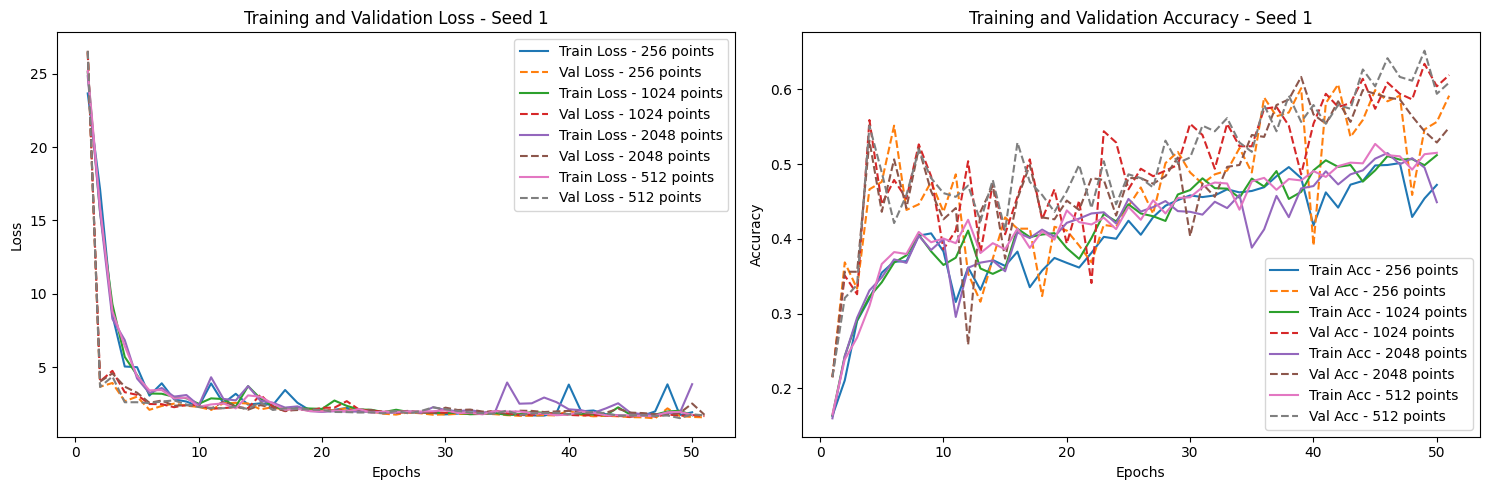

In [ ]:
datasets = [dataset_transformed_256, dataset_transformed_1024, dataset_transformed_2048, dataset_transformed_512]
results_table = {}
metrics_per_dataset = {}  # To store metrics for plotting

for dataset in datasets:
    mean_acc, std_dev, all_metrics = train_and_evaluate_PointCloud(dataset, DATA_PERTURB_SEEDS)
    dataset_key = str(len(dataset[0].pos))
    results_table[dataset_key] = {'Test Accuracy': mean_acc, 'Standard Deviation': std_dev}
    metrics_per_dataset[dataset_key] = all_metrics

# Display results
print("Results:")
for key, value in results_table.items():
    print(f"Dataset with {key} points per cloud: Test Accuracy = {value['Test Accuracy']:.2f} +/- {value['Standard Deviation']:.2f}")

# Plotting results for each dataset
plot_combined_results(metrics_per_dataset, "combined_results_pointcloud.png")

### 2.2.3 PointNet

In [ ]:
def random_rotate_and_jitter(point_set):
    """
    Data augmentation by applying random rotation and jitter as well as scale & centerize.
    Logic taken from https://github.com/fxia22/pointnet.pytorch/blob/master/pointnet/dataset.py
    """
    # Apply random rotation
    theta = np.random.uniform(0, np.pi * 2)
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                                [np.sin(theta), np.cos(theta)]])
    point_set[:, [0, 2]] = point_set[:, [0, 2]].dot(rotation_matrix)

    # Apply jitter
    point_set += np.random.normal(0, 0.01, size=point_set.shape)

    # Normalization (centering) and Scaling
    point_set -= np.mean(point_set, axis=0)
    max_distance = np.max(np.sqrt(np.sum(point_set ** 2, axis=1)))
    point_set /= max_distance

    return point_set

def custom_collate_fn(batch):
    """
    Custom collate function to get data into the right shape for PointNet.
    """
    new_batch = []
    for item in batch:
        pos, y = item.pos, item.y
        pos = random_rotate_and_jitter(pos.numpy())
        new_batch.append((torch.tensor(pos), y))
    batch = new_batch
    data = torch.stack([item[0] for item in batch])
    labels = torch.cat([item[1] for item in batch], dim=0)

    # Reshape data to (batch_size, num_features, num_points)
    data = data.transpose(1, 2)
    return data, labels

In [ ]:
class PointNetWrapper(pl.LightningModule):
    """
    A Pytorch Lightning Wrapper to train
    sequence models (classifiers/regressors)
    """
    def __init__(self, dataset, model, device_name, learning_rate=0.01, use_lr_scheduler=False, weight_decay=0.01, schedule_patience=20):
        super().__init__()
        self.data = dataset
        self.model = model
        self.loss = nn.CrossEntropyLoss()
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.use_lr_scheduler = use_lr_scheduler
        self.patience = schedule_patience
        self.device_name = device_name  # Rename the attribute to device_name

        self.train_loss = []
        self.val_loss = []
        self.train_accuracy = []
        self.val_accuracy = []

        self.train_proba = []
        self.train_labels = []
        self.val_proba = []
        self.val_labels = []

        self.epoch_train_loss = []
        self.epoch_val_loss = []
        self.epoch_train_accuracy = []
        self.epoch_val_accuracy = []

        self.test_loss = []
        self.test_proba = []
        self.test_labels = []
        self.epoch_test_loss = []
        self.epoch_test_accuracy = []

        self.save_hyperparameters(ignore=["model", "dataset"])

    def forward(self, data):
        # data should have dimension (batch_size, num_points, num_features)
        output, _, _ = self.model(data)  # PointNet outputs logits and transformation matrices
        return output

    def compute_loss(self, logits, labels):
        return self.loss(logits, labels)


    def on_train_epoch_end(self):
        train_loss = np.mean(self.train_loss)
        self.log("train/loss", train_loss, prog_bar=True)

        train_proba = np.concatenate(self.train_proba)
        train_labels = np.concatenate(self.train_labels)
        train_acc = accuracy_score(train_labels, np.argmax(train_proba, axis=-1))
        self.log("train/accuracy", train_acc, prog_bar=False)

        self.epoch_train_loss.append(train_loss)
        self.epoch_train_accuracy.append(train_acc)

        self.train_loss.clear()
        self.train_proba.clear()
        self.train_labels.clear()

    def on_validation_epoch_end(self):
        val_loss = float(np.mean(self.val_loss))
        self.log("val/loss", val_loss, prog_bar=True)

        val_proba = np.concatenate(self.val_proba)
        val_labels = np.concatenate(self.val_labels)
        val_acc = accuracy_score(val_labels, np.argmax(val_proba, axis=-1))
        self.log("val/accuracy", val_acc, prog_bar=False)

        self.epoch_val_loss.append(val_loss)
        self.epoch_val_accuracy.append(val_acc)

        self.val_loss.clear()
        self.val_proba.clear()
        self.val_labels.clear()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        if self.use_lr_scheduler:
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.25, patience=self.patience, min_lr=0.0001)
            return {'optimizer': optimizer, 'lr_scheduler': scheduler, 'monitor': 'train/loss'}
        return optimizer

    def training_step(self, batch, batch_idx):
        data, labels = batch  # Unpack the data and labels
        data = data.to(self.device_name)  # Move data to the specified device
        labels = labels.to(self.device_name)  # Move labels to the specified device
        logits = self(data)  # Pass only the data to the model
        loss = self.compute_loss(logits, labels)

        train_proba = F.softmax(logits, dim=-1).detach().cpu().numpy()
        train_labels = labels.detach().cpu().numpy()

        self.train_loss.append(loss.detach().cpu().numpy())
        self.train_proba.append(train_proba)
        self.train_labels.append(train_labels)

        return loss

    def validation_step(self, batch, batch_idx):
        data, labels = batch  # Unpack the data and labels
        data = data.to(self.device_name)  # Move data to the specified device
        labels = labels.to(self.device_name)  # Move labels to the specified device
        logits = self(data)  # Pass only the data to the model
        loss = self.compute_loss(logits, labels)

        val_proba = F.softmax(logits, dim=-1).detach().cpu().numpy()
        val_labels = labels.detach().cpu().numpy()

        self.val_loss.append(loss.detach().cpu().numpy())
        self.val_proba.append(val_proba)
        self.val_labels.append(val_labels)

    def test_step(self, batch, batch_idx):
        data, labels = batch
        data = data.to(self.device_name)  # Move data to the specified device
        labels = labels.to(self.device_name)  # Move labels to the specified device
        logits = self(data)
        loss = self.compute_loss(logits, labels)

        test_proba = F.softmax(logits, dim=-1).detach().cpu().numpy()
        test_labels = labels.detach().cpu().numpy()

        self.test_loss.append(loss.detach().cpu().numpy())
        self.test_proba.append(test_proba)
        self.test_labels.append(test_labels)


    def on_test_epoch_end(self):
        test_loss = float(np.mean(self.test_loss))
        self.log("test/loss", test_loss, prog_bar=True)

        test_proba = np.concatenate(self.test_proba)
        test_labels = np.concatenate(self.test_labels)
        test_acc = accuracy_score(test_labels, np.argmax(test_proba, axis=-1))
        self.log("test/accuracy", test_acc, prog_bar=False)

        self.epoch_test_loss.append(test_loss)  # Corrected to append to test loss
        self.epoch_test_accuracy.append(test_acc)  # Corrected to append to test accuracy

        self.test_loss.clear()  # Clearing test data
        self.test_proba.clear()
        self.test_labels.clear()


In [ ]:
"""
This is the PointNet model code taken from https://github.com/fxia22/pointnet.pytorch/tree/master/pointnet/model.py
"""

class STN3d(nn.Module):
    def __init__(self):
        super(STN3d, self).__init__()
        self.conv1 = torch.nn.Conv1d(3, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 9)
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)


    def forward(self, x):
        batchsize = x.size()[0]
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)

        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)

        iden = Variable(torch.from_numpy(np.array([1,0,0,0,1,0,0,0,1]).astype(np.float32))).view(1,9).repeat(batchsize,1)
        if x.is_cuda:
            iden = iden.cuda()
        x = x + iden
        x = x.view(-1, 3, 3)
        return x

class STNkd(nn.Module):
    def __init__(self, k=64):
        super(STNkd, self).__init__()
        self.conv1 = torch.nn.Conv1d(k, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k*k)
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)

        self.k = k

    def forward(self, x):
        batchsize = x.size()[0]
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)

        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)

        iden = Variable(torch.from_numpy(np.eye(self.k).flatten().astype(np.float32))).view(1,self.k*self.k).repeat(batchsize,1)
        if x.is_cuda:
            iden = iden.cuda()
        x = x + iden
        x = x.view(-1, self.k, self.k)
        return x

class PointNetfeat(nn.Module):
    def __init__(self, global_feat = True, feature_transform = False):
        super(PointNetfeat, self).__init__()
        self.stn = STN3d()
        self.conv1 = torch.nn.Conv1d(3, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.global_feat = global_feat
        self.feature_transform = feature_transform
        if self.feature_transform:
            self.fstn = STNkd(k=64)

    def forward(self, x):

        n_pts = x.size()[2]
        trans = self.stn(x)
        x = x.transpose(2, 1)
        x = torch.bmm(x, trans)
        x = x.transpose(2, 1)
        x = F.relu(self.bn1(self.conv1(x)))

        if self.feature_transform:
            trans_feat = self.fstn(x)
            x = x.transpose(2,1)
            x = torch.bmm(x, trans_feat)
            x = x.transpose(2,1)
        else:
            trans_feat = None

        pointfeat = x
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)
        if self.global_feat:
            return x, trans, trans_feat
        else:
            x = x.view(-1, 1024, 1).repeat(1, 1, n_pts)
            return torch.cat([x, pointfeat], 1), trans, trans_feat

class PointNetCls(nn.Module):
    def __init__(self, k=2, feature_transform=False):
        super(PointNetCls, self).__init__()
        self.feature_transform = feature_transform
        self.feat = PointNetfeat(global_feat=True, feature_transform=feature_transform)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k)
        self.dropout = nn.Dropout(p=0.5) # Changed from 0.3
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.relu = nn.ReLU()

    def forward(self, x):
        x, trans, trans_feat = self.feat(x)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.dropout(self.fc2(x))))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1), trans, trans_feat

In [ ]:
def train_and_evaluate_PointNet(dataset, seeds, max_epochs=10, accelerator='cuda'):
    all_metrics = []

    for seed in seeds:
        torch.manual_seed(seed)

        # Split dataset
        train_size = int(0.8 * len(dataset))
        val_size = int(0.1 * len(dataset))
        test_size = len(dataset) - train_size - val_size

        train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=custom_collate_fn)
        val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=custom_collate_fn)
        test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=custom_collate_fn)

        # Model and training setup
        model = PointNetCls(10).to(device)  # Explicitly set the device
        model_wrapper = PointNetWrapper(dataset, model, device_name=device, learning_rate=0.001, use_lr_scheduler=True, weight_decay=0.01, schedule_patience=20)

        trainer = pl.Trainer(
            accelerator=accelerator,
            max_epochs=max_epochs,
            callbacks=[
                EarlyStopping(
                    monitor="val/loss",
                    mode="min",
                    patience=20,
                    min_delta=0.001
                )
            ]
        )
        # Train the model
        trainer.fit(model_wrapper, train_loader, val_loader)

        # Collecting metrics
        metrics = {
            "train_loss": model_wrapper.epoch_train_loss,
            "train_accuracy": model_wrapper.epoch_train_accuracy,
            "val_loss": model_wrapper.epoch_val_loss,
            "val_accuracy": model_wrapper.epoch_val_accuracy
        }
        all_metrics.append(metrics)

    # Evaluate on test set after all epochs and seeds
    test_accuracies = []
    for metric_set in all_metrics:
        model_wrapper = PointNetWrapper(dataset, model, device_name=device, learning_rate=0.001, use_lr_scheduler=True, weight_decay=0.01, schedule_patience=20)
        trainer = pl.Trainer(accelerator=accelerator, max_epochs=max_epochs)
        trainer.test(model_wrapper, test_loader)  # Test evaluation after all training and validation is complete

        # Append the test accuracy of each seed
        test_accuracies.append(model_wrapper.epoch_test_accuracy[-1])

    # Calculate mean and standard deviation of test accuracies
    mean_acc = np.mean(test_accuracies)
    std_dev = np.std(test_accuracies)
    return mean_acc, std_dev, all_metrics


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params
-------------------------------------------
0 | model | PointNetCls      | 1.6 M 
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.426     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/accuracy       │           0.745           │
│         test/loss         │    0.8233935236930847     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params
-------------------------------------------
0 | model | PointNetCls      | 1.6 M 
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.426     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/accuracy       │           0.715           │
│         test/loss         │    0.8132258057594299     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params
-------------------------------------------
0 | model | PointNetCls      | 1.6 M 
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.426     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/accuracy       │           0.71            │
│         test/loss         │    0.8103953003883362     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params
-------------------------------------------
0 | model | PointNetCls      | 1.6 M 
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.426     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/accuracy       │           0.475           │
│         test/loss         │    1.6308151483535767     │
└───────────────────────────┴───────────────────────────┘

Results:
Dataset with 1024 points per cloud: Test Accuracy = 0.74 +/- 0.00
Dataset with 2048 points per cloud: Test Accuracy = 0.71 +/- 0.00
Dataset with 256 points per cloud: Test Accuracy = 0.71 +/- 0.00
Dataset with 512 points per cloud: Test Accuracy = 0.47 +/- 0.00


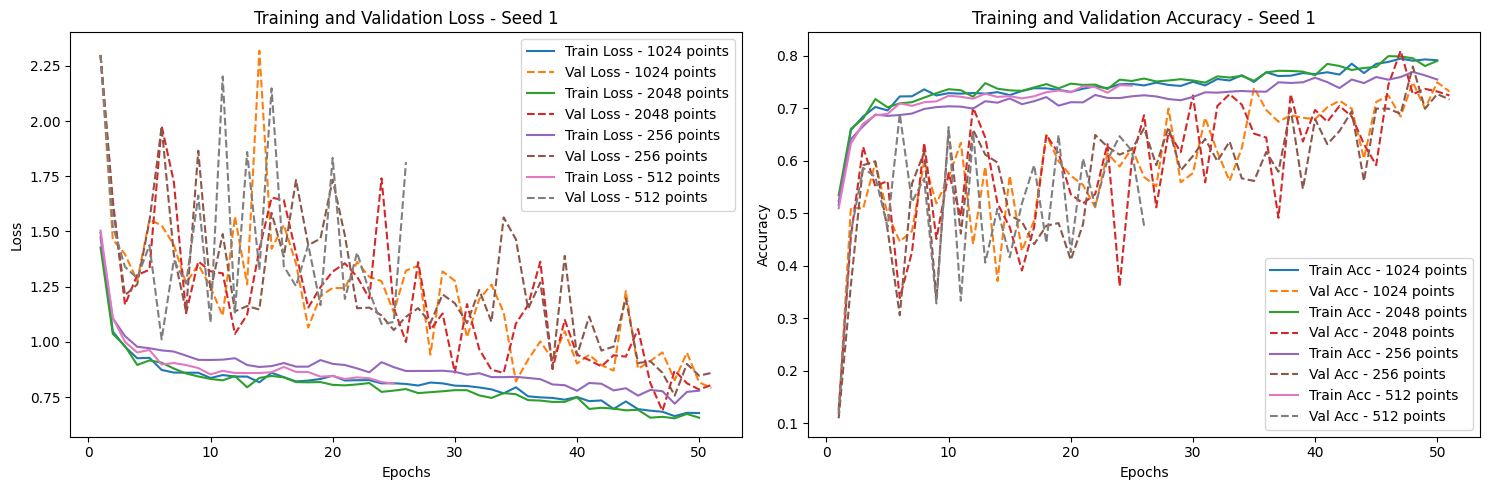

In [ ]:
datasets = [dataset_transformed_1024, dataset_transformed_2048, dataset_transformed_256, dataset_transformed_512]
results_table = {}
metrics_per_dataset = {}  # To store metrics for plotting

if torch.cuda.is_available():
  accelerator = 'cuda'
else:
  accelerator = 'cpu'

for dataset in datasets:
    mean_acc, std_dev, all_metrics = train_and_evaluate_PointNet(dataset, DATA_PERTURB_SEEDS, max_epochs=50, accelerator='cuda')
    dataset_key = str(len(dataset[0].pos))
    results_table[dataset_key] = {'Test Accuracy': mean_acc, 'Standard Deviation': std_dev}
    metrics_per_dataset[dataset_key] = all_metrics

# Display results
print("Results:")
for key, value in results_table.items():
    print(f"Dataset with {key} points per cloud: Test Accuracy = {value['Test Accuracy']:.2f} +/- {value['Standard Deviation']:.2f}")

# Plotting results for each dataset
plot_combined_results(metrics_per_dataset, "test.png")


## 2.3 Meshes



### Loading Mesh data and adding positional embeddings

In [ ]:
from torch_geometric.transforms import Compose, FaceToEdge

#Random node embeddings
def add_node_attribute(data, feat_size = 3):
    data.x = torch.randn(data.num_nodes, feat_size)
    return data
pre_transform = Compose((add_node_attribute,FaceToEdge(remove_faces=True)))
mesh_dataset = ModelNet(root='...', name='10',transform=pre_transform) #, transform=transform)
# Exploring the dataset
print(f"Dataset size: {len(mesh_dataset)}")
print(f"Number of classes: {mesh_dataset.num_classes}")
print(f"Example data point: {mesh_dataset[0]}")

In [ ]:
#Positonal node embeddings
def add_node_attribute_pos(data):
    data.x = data.pos
    return data
pre_transform = Compose((add_node_attribute_pos,FaceToEdge(remove_faces=True)))
mesh_dataset_with_pos = ModelNet(root='...', name='10',transform=pre_transform) #, transform=transform)
# Exploring the dataset
print(f"Dataset size: {len(mesh_dataset)}")
print(f"Number of classes: {mesh_dataset.num_classes}")
print(f"Example data point: {mesh_dataset[0]}")

### Basic GNN Model + Training Wrapper

## 2.3 Meshes
Loading and visualising a sample as a Mesh

In [ ]:
mesh_dataset = ModelNet(root='...', name='10') #, transform=transform)
# Exploring the dataset
print(f"Dataset size: {len(mesh_dataset)}")
print(f"Number of classes: {mesh_dataset.num_classes}")
print(f"Example data point: {mesh_dataset[0]}")

Dataset size: 3991
Number of classes: 10
Example data point: Data(pos=[3456, 3], face=[3, 5456], y=[1])


In [ ]:
def visualise_mesh(mesh):
    o3d_mesh = o3d.geometry.TriangleMesh()
    o3d_mesh.vertices = o3d.utility.Vector3dVector(mesh.pos)
    o3d_mesh.triangles = o3d.utility.Vector3iVector(mesh.face.t())
    o3d.visualization.draw_geometries([o3d_mesh],mesh_show_wireframe=True)
    pass
visualise_mesh(mesh_dataset[0])

### 2.3.1 Basic Model with random node embeddings
We initialise a simple GNN without explicit node embeddings. Instead, we use the node degrees to project to an initial embedding

In [ ]:
# Load ModelNet10 dataset
# transform = T.SamplePoints(1024)
mesh_dataset_2_3_1 = ModelNet(root='...', name='10',transform=FaceToEdge(remove_faces=True)) #, transform=transform)
# Exploring the dataset
print(f"Dataset size: {len(mesh_dataset_2_3_1)}")
print(f"Number of classes: {mesh_dataset_2_3_1.num_classes}")
print(f"Example data point: {mesh_dataset_2_3_1[0]}")

Dataset size: 3991
Number of classes: 10
Example data point: Data(pos=[3456, 3], y=[1], edge_index=[2, 17712])


In [ ]:
# Baseline model:
class GCNBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, dropout_rate=0.5, batch_norm=True):
        super(GCNBlock, self).__init__()


        self.conv = GCNConv(in_channels, out_channels)
        self.dropout = torch.nn.Dropout(dropout_rate)
        self.batch_norm = batch_norm

        if self.batch_norm:
            self.bn = torch.nn.BatchNorm1d(out_channels)

    def forward(self, x, edge_index):
        x = self.conv(x, edge_index)
        if self.batch_norm:
            x = self.bn(x)
        x = F.relu(x)
        x = self.dropout(x)
        return x

class SimpleGCN_No_Embeddings(torch.nn.Module):
    def __init__(self, num_features, layer_configs, num_classes):
        super(SimpleGCN_No_Embeddings, self).__init__()
        self.add_node_embedding = torch.nn.Linear(1, 3)
        initial_layer = layer_configs[0]
        self.bn_init = torch.nn.BatchNorm1d(3)
        self.initial = GCNBlock(num_features, initial_layer['out_channels'], initial_layer['dropout_rate'], initial_layer['batch_norm'])
        self.num_classes = num_classes
        self.hidden_layers = torch.nn.ModuleList()
        for layer_config in layer_configs[1:]:
            self.hidden_layers.append(GCNBlock(layer_config['in_channels'], layer_config['out_channels'], layer_config['dropout_rate'], layer_config['batch_norm']))

        self.final_layer = torch.nn.Linear(layer_configs[-1]['out_channels'], num_classes)
    def forward(self, edge_index, batch):
        #Begin by initialising a node embedding based on the degree of the node
        deg = torch_geometric.utils.degree(edge_index[0]).unsqueeze(1).float()
        x = self.add_node_embedding(deg)
        x = self.bn_init(x)
        #Pass through the initial layer
        x = self.initial(x, edge_index)

        #Pass through hidden layers
        for layer in self.hidden_layers:
            x = layer(x, edge_index)
        x = global_mean_pool(x, batch)

        x = self.final_layer(x)
        return x

layer_configs = [
    {"in_channels": 3, "out_channels": 64, "dropout_rate": 0.5, "batch_norm": False}
]

In [ ]:
DATA_PERTURB_SEEDS = [123]  # 3 distinct seeds for data perturbations
train_size = 512 #Due to memory constrainst, we limit the mesh model samples
val_size = 256
test_size = 256
batch_size = 256
learning_rate = 0.0005
weight_decay = 0.001
scheduler = True
schedule_patience = 20
epochs = 10
results = {}
device = 'cpu'

for perturb_seed in DATA_PERTURB_SEEDS:

    # Set seed
    torch.manual_seed(perturb_seed)

    # Split dataset into train and test
    dataset = mesh_dataset_2_3_1[:train_size + val_size + test_size]
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size,test_size])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Instantiate training wrapper
    model = SimpleGCN_No_Embeddings(3, layer_configs, 10)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    train_loss_for_epoch = []
    test_loss_for_epoch = []
    train_accuracies_for_epoch = []
    test_accuracies_for_epoch = []

    for epoch in range(epochs):
        total_train_loss = 0
        total_val_loss = 0
        total_train_accuracy = 0
        total_val_accuracy = 0
        for batch in train_loader:
            optimizer.zero_grad()
            batch = batch.to(device)
            out = model(batch.edge_index, batch.batch)
            loss = F.cross_entropy(out, batch.y)
            total_train_loss += loss.item()
            predicted_tags = np.argmax(model(batch.edge_index, batch.batch).detach().numpy(),axis=1)
            total_train_accuracy += accuracy_score(batch.y.detach().numpy(), predicted_tags)
            loss.backward()
            optimizer.step()
        for batch in val_loader:
            batch = batch.to(device)
            out = model(batch.edge_index, batch.batch)
            loss = F.cross_entropy(out, batch.y)
            total_val_loss += loss.item()
            predicted_tags = np.argmax(model(batch.edge_index, batch.batch).detach().numpy(),axis=1)
            total_val_accuracy= accuracy_score(batch.y, predicted_tags)
        train_loss_for_epoch.append(total_train_loss/len(train_loader))
        test_loss_for_epoch.append(total_val_loss/len(val_loader))
        train_accuracies_for_epoch.append(total_train_accuracy/len(train_loader))
        test_accuracies_for_epoch.append(total_val_accuracy/len(val_loader))
        print("Epoch: {}, Train Loss: {}, Val Loss: {}, Train Accuracy: {}, Val Accuracy: {}".format(epoch, total_train_loss/len(train_loader), total_val_loss/len(val_loader), total_train_accuracy/len(train_loader), total_val_accuracy/len(val_loader)))

    # Save the results
    key = f"{perturb_seed}"

    results[key] = {
        "train_loss": train_loss_for_epoch,
        "train_accuracy": train_accuracies_for_epoch,
        "val_loss": test_loss_for_epoch,
        "val_accuracy": test_accuracies_for_epoch,
      }


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Train Loss: 2.3152060508728027, Val Loss: 2.3073320388793945, Train Accuracy: 0.037109375, Val Accuracy: 0.1015625
Epoch: 1, Train Loss: 2.303479552268982, Val Loss: 2.294826030731201, Train Accuracy: 0.119140625, Val Accuracy: 0.1640625
Epoch: 2, Train Loss: 2.292029023170471, Val Loss: 2.282609462738037, Train Accuracy: 0.220703125, Val Accuracy: 0.31640625
Epoch: 3, Train Loss: 2.280479907989502, Val Loss: 2.2704145908355713, Train Accuracy: 0.345703125, Val Accuracy: 0.41015625
Epoch: 4, Train Loss: 2.269212245941162, Val Loss: 2.2584831714630127, Train Accuracy: 0.419921875, Val Accuracy: 0.42578125
Epoch: 5, Train Loss: 2.258082866668701, Val Loss: 2.2469921112060547, Train Accuracy: 0.451171875, Val Accuracy: 0.4453125
Epoch: 6, Train Loss: 2.246851325035095, Val Loss: 2.2346622943878174, Train Accuracy: 0.455078125, Val Accuracy: 0.453125
Epoch: 7, Train Loss: 2.235529661178589, Val Loss: 2.223074436187744, Train Accuracy: 0.45703125, Val Accuracy: 0.4609375
Epoch: 8,

In [ ]:
#Get test accuracy
total_test_accuracy = 0
for batch in test_loader:
    batch = batch.to(device)
    out = model(batch.edge_index, batch.batch)
    predicted_tags = np.argmax(model(batch.edge_index, batch.batch).detach().numpy(),axis=1)
    total_test_accuracy += accuracy_score(batch.y.detach().numpy(), predicted_tags)
print("Test Accuracy: {}".format(total_test_accuracy/len(test_loader)))


Test Accuracy: 0.48828125


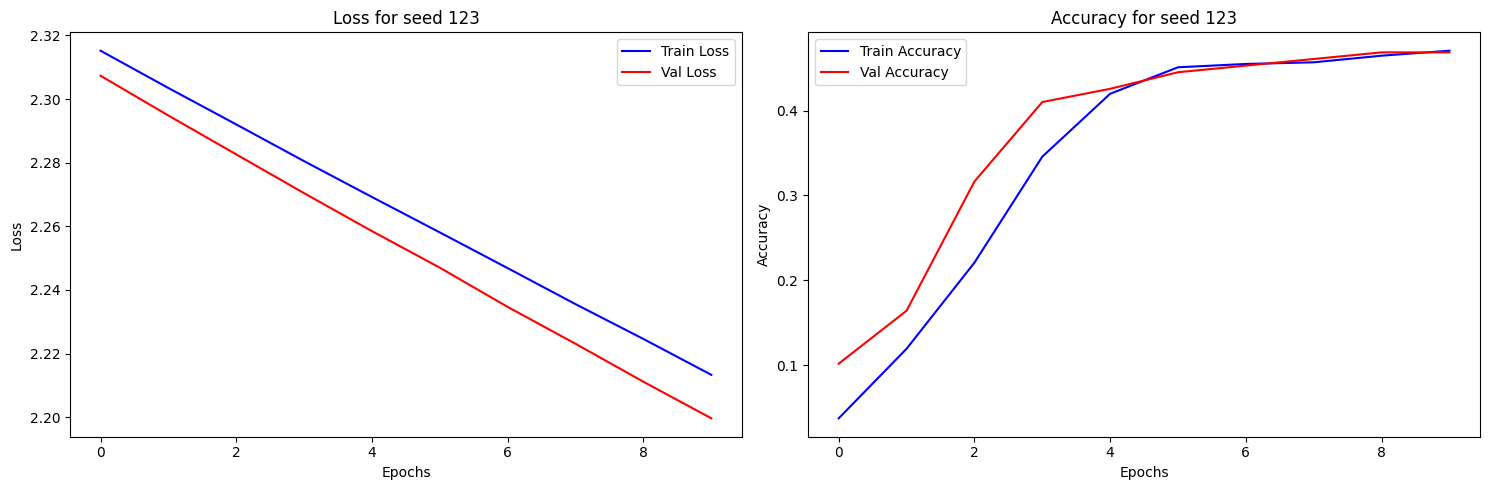

In [ ]:
# Plot the results
train_accuracy = results['123']['train_accuracy']
val_accuracy = results['123']['val_accuracy']
train_loss = results['123']['train_loss']
val_loss = results['123']['val_loss']
epochs = range(1, len(train_loss) + 1)
#Subplots: one with loss curve one with accuracy curves
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].plot(train_loss, 'b-', label='Train Loss')
axes[0].plot(val_loss, 'r-', label='Val Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].set_title(f"Loss for seed {123}")
axes[1].plot(train_accuracy, 'b-', label='Train Accuracy')
axes[1].plot(val_accuracy, 'r-', label='Val Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].set_title(f"Accuracy for seed {123}")
plt.tight_layout()
plt.show()


### 2.3.1 Basic Model with positonal node embeddings

In [ ]:
# Load ModelNet10 dataset
# transform = T.SamplePoints(1024)
from torch_geometric.transforms import Compose, FaceToEdge
def add_node_attribute_pos(data):
    data.x = data.pos
    return data
pre_transform = Compose((add_node_attribute_pos,FaceToEdge(remove_faces=True)))
mesh_dataset_2_3_2 = ModelNet(root='...', name='10',transform=pre_transform) #, transform=transform)
# Exploring the dataset
print(f"Dataset size: {len(mesh_dataset_2_3_2)}")
print(f"Number of classes: {mesh_dataset_2_3_2.num_classes}")
print(f"Example data point: {mesh_dataset_2_3_2[0]}")

Dataset size: 3991
Number of classes: 10
Example data point: Data(pos=[3456, 3], y=[1], x=[3456, 3], edge_index=[2, 17712])


In [ ]:
# Baseline model with positonal embeddings:
class GCNBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, dropout_rate=0.5, batch_norm=True):
        super(GCNBlock, self).__init__()


        self.conv = GCNConv(in_channels, out_channels)
        self.dropout = torch.nn.Dropout(dropout_rate)
        self.batch_norm = batch_norm

        if self.batch_norm:
            self.bn = torch.nn.BatchNorm1d(out_channels)

    def forward(self, x, edge_index):
        x = self.conv(x, edge_index)
        if self.batch_norm:
            x = self.bn(x)
        x = F.relu(x)
        x = self.dropout(x)
        return x

class SimpleGCN_Pos_Embeddings(torch.nn.Module):
    def __init__(self, num_features, layer_configs, num_classes):
        super(SimpleGCN_Pos_Embeddings, self).__init__()
        #self.add_node_embedding = torch.nn.Linear(1, 3)
        initial_layer = layer_configs[0]
        #self.bn_init = torch.nn.BatchNorm1d(3)
        self.initial = GCNBlock(num_features, initial_layer['out_channels'], initial_layer['dropout_rate'], initial_layer['batch_norm'])
        self.num_classes = num_classes
        self.hidden_layers = torch.nn.ModuleList()
        for layer_config in layer_configs[1:]:
            self.hidden_layers.append(GCNBlock(layer_config['in_channels'], layer_config['out_channels'], layer_config['dropout_rate'], layer_config['batch_norm']))

        self.final_layer = torch.nn.Linear(layer_configs[-1]['out_channels'], num_classes)
    def forward(self, x, edge_index, batch):
        #Begin by initialising a node embedding based on the degree of the node
        #deg = torch_geometric.utils.degree(edge_index[0]).unsqueeze(1).float()
        #x = self.add_node_embedding(deg)
        #x = self.bn_init(x)
        #Pass through the initial layer
        x = self.initial(x, edge_index)
        #Pass through hidden layers
        for layer in self.hidden_layers:
            x = layer(x, edge_index)
        x = global_mean_pool(x, batch)

        x = self.final_layer(x)
        return x

layer_configs = [
    {"in_channels": 3, "out_channels": 64, "dropout_rate": 0.5, "batch_norm": False}
]

In [ ]:
DATA_PERTURB_SEEDS = [123]  # 3 distinct seeds for data perturbations
train_size = 512
val_size = 256
test_size = 256
batch_size = 256
learning_rate = 0.001
weight_decay = 0.001
scheduler = True
schedule_patience = 20
epochs = 10
results = {}
device = 'cpu'

for perturb_seed in DATA_PERTURB_SEEDS:

    # Set seed
    torch.manual_seed(perturb_seed)

    # Split dataset into train and test
    dataset = mesh_dataset_2_3_2[:train_size + val_size + test_size]
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size,test_size])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Instantiate training wrapper
    model = SimpleGCN_Pos_Embeddings(3, layer_configs, 10)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    train_loss_for_epoch = []
    test_loss_for_epoch = []
    train_accuracies_for_epoch = []
    test_accuracies_for_epoch = []

    for epoch in range(epochs):
        total_train_loss = 0
        total_val_loss = 0
        total_train_accuracy = 0
        total_val_accuracy = 0
        for batch in train_loader:
            optimizer.zero_grad()
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            loss = F.cross_entropy(out, batch.y)
            total_train_loss += loss.item()
            predicted_tags = np.argmax(model(batch.x, batch.edge_index, batch.batch).detach().numpy(),axis=1)
            total_train_accuracy += accuracy_score(batch.y.detach().numpy(), predicted_tags)
            loss.backward()
            optimizer.step()
        for batch in val_loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            loss = F.cross_entropy(out, batch.y)
            total_val_loss += loss.item()
            predicted_tags = np.argmax(model(batch.x, batch.edge_index, batch.batch).detach().numpy(),axis=1)
            total_val_accuracy= accuracy_score(batch.y, predicted_tags)
        train_loss_for_epoch.append(total_train_loss/len(train_loader))
        test_loss_for_epoch.append(total_val_loss/len(val_loader))
        train_accuracies_for_epoch.append(total_train_accuracy/len(train_loader))
        test_accuracies_for_epoch.append(total_val_accuracy/len(val_loader))
        print("Epoch: {}, Train Loss: {}, Val Loss: {}, Train Accuracy: {}, Val Accuracy: {}".format(epoch, total_train_loss/len(train_loader), total_val_loss/len(val_loader), total_train_accuracy/len(train_loader), total_val_accuracy/len(val_loader)))

    # Save the results
    key = f"{perturb_seed}"

    results[key] = {
        "train_loss": train_loss_for_epoch,
        "train_accuracy": train_accuracies_for_epoch,
        "val_loss": test_loss_for_epoch,
        "val_accuracy": test_accuracies_for_epoch,
      }

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Train Loss: 36.52789306640625, Val Loss: 25.09416961669922, Train Accuracy: 0.00390625, Val Accuracy: 0.00390625
Epoch: 1, Train Loss: 26.287772178649902, Val Loss: 18.81846046447754, Train Accuracy: 0.0078125, Val Accuracy: 0.01171875
Epoch: 2, Train Loss: 16.936165809631348, Val Loss: 11.68689250946045, Train Accuracy: 0.0234375, Val Accuracy: 0.0234375
Epoch: 3, Train Loss: 7.524979829788208, Val Loss: 6.081698417663574, Train Accuracy: 0.08203125, Val Accuracy: 0.3203125
Epoch: 4, Train Loss: 4.571096897125244, Val Loss: 5.385959625244141, Train Accuracy: 0.3671875, Val Accuracy: 0.46484375
Epoch: 5, Train Loss: 3.4720791578292847, Val Loss: 4.7588653564453125, Train Accuracy: 0.484375, Val Accuracy: 0.5078125
Epoch: 6, Train Loss: 3.331787109375, Val Loss: 4.178971290588379, Train Accuracy: 0.541015625, Val Accuracy: 0.5078125
Epoch: 7, Train Loss: 3.4511353969573975, Val Loss: 3.742776870727539, Train Accuracy: 0.568359375, Val Accuracy: 0.53515625
Epoch: 8, Train Loss:

In [ ]:
#Get test accuracy
total_test_accuracy = 0
for batch in test_loader:
    batch = batch.to(device)
    out = model(batch.x, batch.edge_index, batch.batch)
    predicted_tags = np.argmax(model(batch.x, batch.edge_index, batch.batch).detach().numpy(),axis=1)
    total_test_accuracy += accuracy_score(batch.y.detach().numpy(), predicted_tags)
print("Test Accuracy: {}".format(total_test_accuracy/len(test_loader)))


Test Accuracy: 0.59765625


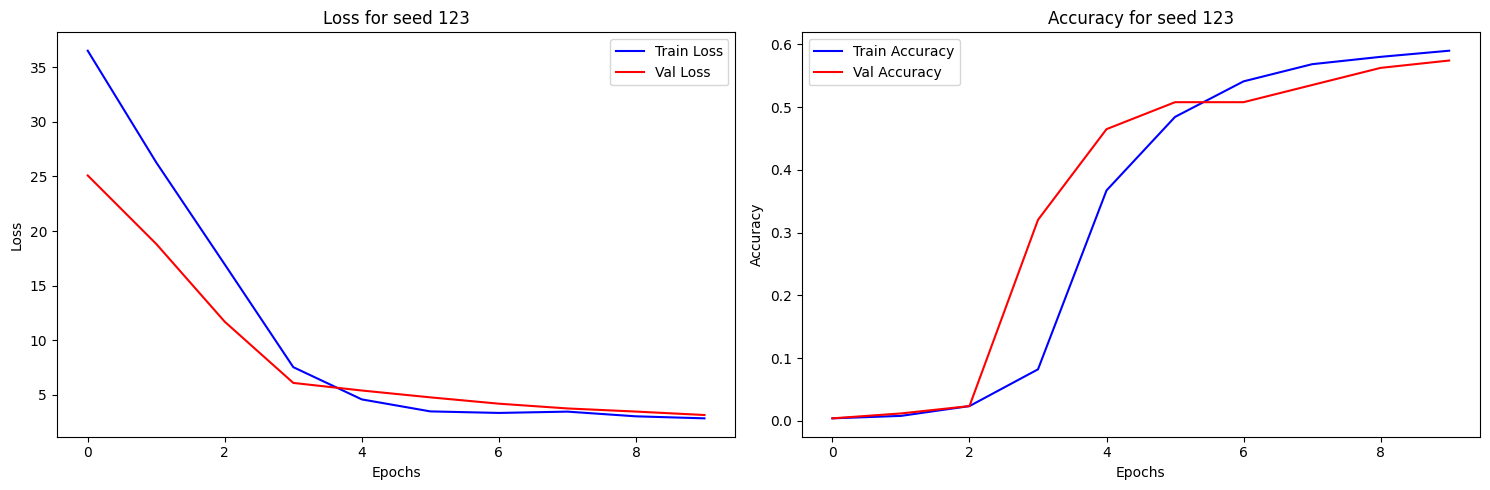

In [ ]:
# Plot the results
train_accuracy = results['123']['train_accuracy']
val_accuracy = results['123']['val_accuracy']
train_loss = results['123']['train_loss']
val_loss = results['123']['val_loss']
epochs = range(1, len(train_loss) + 1)
#Subplots: one with loss curve one with accuracy curves
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].plot(train_loss, 'b-', label='Train Loss')
axes[0].plot(val_loss, 'r-', label='Val Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].set_title(f"Loss for seed {123}")
axes[1].plot(train_accuracy, 'b-', label='Train Accuracy')
axes[1].plot(val_accuracy, 'r-', label='Val Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].set_title(f"Accuracy for seed {123}")
plt.tight_layout()
plt.show()


### 2.3.3 Rotationally Invariant GNN
We recognise that the positional embeddings used in the previous GNN are not rotatioanlly invariant. That being said, PointNet perfomance does not suffer from rotations since 1) the training function trains on random rotations and jitters 2) the model does not use the true 3D data and instead just point clouds, therefore invariant to a change in ordering.

We create a custom message passing layer which uses relative distances as an input to an MLP for aggregation. Relative distances are preserved under all rotations

In [ ]:
#Rotationally Invariant Message Passing Protocol using Relative Distances
class RIMP(MessagePassing):
    def __init__(self, in_channels, out_channels, normalize = True,
                 bias = False, aggr='add', **kwargs):
        super(RIMP, self).__init__(aggr=aggr)
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.lin_l = torch.nn.Linear(1, out_channels)
        self.normalize = normalize


    def forward(self, x, edge_index, size = None):

        row, col = edge_index
        self.edge_index = edge_index
        self.x = x
        norm = torch_geometric.utils.degree(row, x.size(0), dtype=x.dtype).pow(-1) #normalization factor as the neighbour size
        agg_term = self.propagate(edge_index, x=x, norm=1)
        out = agg_term
        return out

    def aggregate(self, inputs, index):

        return scatter(inputs, index, dim=self.node_dim, reduce="mean")
    def message(self, x_i, x_j):
        pos_diff= x_i-x_j
        dists = torch.norm(pos_diff, dim=-1).unsqueeze(1)
        return self.lin_l(dists)

In [ ]:
#Example roation around z axis by angle theta
def rotate_matrix(coords, angle):
    node_embedings_post_rotation = torch.zeros(coords.shape)
    for idx, node in enumerate(coords):
        rotation = torch.tensor([[math.cos(angle), math.sin(angle), 0],[-math.sin(angle), math.cos(angle), 0],[0, 0, 1]])
        node_embedings_post_rotation[idx] = torch.matmul(rotation, node)
    return node_embedings_post_rotation

In [ ]:
#Assertion Check for Rotation Invariance
node_embedings_pre_rotation = torch.rand(4, 3)# A graph with 4 nodes and 8 dimensional node features
edge_index = torch.tensor([[0, 1, 2, 0, 3],
                            [1, 0, 1, 3, 2]], dtype=torch.long) # Example edge index
custom_layer = RIMP(in_channels=3, out_channels=3)
transformed_node_embedings_pre_rotation = custom_layer(node_embedings_pre_rotation, edge_index)
angle = torch.rand(1)
transformed_node_embedings_pre_rotation = custom_layer(node_embedings_pre_rotation, edge_index)
node_embedings_post_rotation = rotate_matrix(node_embedings_pre_rotation,angle)
transformed_node_embedings_post_rotation = custom_layer(node_embedings_post_rotation, edge_index)

assert torch.allclose(transformed_node_embedings_pre_rotation,transformed_node_embedings_post_rotation)

In [ ]:
print("Original input: ", node_embedings_pre_rotation)
transformed_node_embedings_pre_rotation = custom_layer(node_embedings_pre_rotation, edge_index)
angle = math.pi/3
node_embedings_post_rotation = rotate_matrix(node_embedings_pre_rotation,angle)
print("Rotated input: ", node_embedings_post_rotation)
transformed_node_embedings_post_rotation = custom_layer(node_embedings_post_rotation, edge_index)


Original input:  tensor([[0.9301, 0.2936, 0.3411],
        [0.0910, 0.3891, 0.8490],
        [0.0823, 0.3208, 0.2018],
        [0.8943, 0.1409, 0.9863]])
Rotated input:  tensor([[ 0.7194, -0.6587,  0.3411],
        [ 0.3824,  0.1157,  0.8490],
        [ 0.3189,  0.0892,  0.2018],
        [ 0.5692, -0.7040,  0.9863]])


In [ ]:
print("Node features before rotation: ")
print(transformed_node_embedings_pre_rotation)
print("Node features after rotation: ")
print(transformed_node_embedings_post_rotation)

Node features before rotation: 
tensor([[ 0.5261, -0.0640,  1.6635],
        [ 0.4242,  0.0245,  1.5092],
        [ 0.6221, -0.1474,  1.8090],
        [ 0.3304,  0.1061,  1.3671]], grad_fn=<DivBackward0>)
Node features after rotation: 
tensor([[ 0.5261, -0.0640,  1.6635],
        [ 0.4242,  0.0245,  1.5092],
        [ 0.6221, -0.1474,  1.8090],
        [ 0.3304,  0.1061,  1.3671]], grad_fn=<DivBackward0>)


In [ ]:
# Baseline model with positonal embeddings:
class GCNBlock_RI(torch.nn.Module):
    def __init__(self, in_channels, out_channels, dropout_rate=0.5, batch_norm=True):
        super(GCNBlock_RI, self).__init__()


        self.conv = RIMP(in_channels, out_channels)
        self.dropout = torch.nn.Dropout(dropout_rate)
        self.batch_norm = batch_norm

        if self.batch_norm:
            self.bn = torch.nn.BatchNorm1d(out_channels)

    def forward(self, x, edge_index):
        x = self.conv(x, edge_index)
        if self.batch_norm:
            x = self.bn(x)
        x = F.relu(x)
        x = self.dropout(x)
        return x

class SimpleGCN_Rotationally_Invariant(torch.nn.Module):
    def __init__(self, num_features, layer_configs, num_classes):
        super(SimpleGCN_Rotationally_Invariant, self).__init__()
        #self.add_node_embedding = torch.nn.Linear(1, 3)
        initial_layer = layer_configs[0]
        #self.bn_init = torch.nn.BatchNorm1d(3)
        self.initial = GCNBlock_RI(num_features, initial_layer['out_channels'], initial_layer['dropout_rate'], initial_layer['batch_norm'])
        self.num_classes = num_classes
        self.hidden_layers = torch.nn.ModuleList()
        for layer_config in layer_configs[1:]:
            self.hidden_layers.append(GCNBlock_RI(layer_config['in_channels'], layer_config['out_channels'], layer_config['dropout_rate'], layer_config['batch_norm']))

        self.final_layer = torch.nn.Linear(layer_configs[-1]['out_channels'], num_classes)
    def forward(self, x, edge_index, batch):
        #Begin by initialising a node embedding based on the degree of the node
        #deg = torch_geometric.utils.degree(edge_index[0]).unsqueeze(1).float()
        #x = self.add_node_embedding(deg)
        #x = self.bn_init(x)
        #Pass through the initial layer
        x = self.initial(x, edge_index)
        #Pass through hidden layers
        for layer in self.hidden_layers:
            x = layer(x, edge_index)
        x = global_mean_pool(x, batch)

        x = self.final_layer(x)
        return x

layer_configs = [
    {"in_channels": 3, "out_channels": 64, "dropout_rate": 0.5, "batch_norm": False}
]

In [ ]:
DATA_PERTURB_SEEDS = [123]  # 3 distinct seeds for data perturbations
train_size = 512
val_size = 256
test_size = 256
batch_size = 256
learning_rate = 0.001
weight_decay = 0.001
scheduler = True
schedule_patience = 20
epochs = 15
results_ri = {}
device = 'cpu'

for perturb_seed in DATA_PERTURB_SEEDS:

    # Set seed
    torch.manual_seed(perturb_seed)

    # Split dataset into train and test
    dataset = mesh_dataset_2_3_2[:train_size + val_size + test_size]
    train_dataset, val_loader, test_dataset = random_split(dataset, [train_size, val_size,test_size])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Instantiate training wrapper
    model = SimpleGCN_Rotationally_Invariant(3, layer_configs, 10)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    train_loss_for_epoch = []
    test_loss_for_epoch = []
    train_accuracies_for_epoch = []
    test_accuracies_for_epoch = []

    for epoch in range(epochs):
        total_train_loss = 0
        total_test_loss = 0
        total_train_accuracy = 0
        total_test_accuracy = 0
        for batch in train_loader:
            optimizer.zero_grad()
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            loss = F.cross_entropy(out, batch.y)
            total_train_loss += loss.item()
            predicted_tags = np.argmax(out.detach().numpy(),axis=1)
            total_train_accuracy += accuracy_score(batch.y.detach().numpy(), predicted_tags)
            loss.backward()
            optimizer.step()
        for batch in val_loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            loss = F.cross_entropy(out, batch.y)
            total_test_loss += loss.item()
            predicted_tags = np.argmax(out.detach().numpy(),axis=1)
            total_test_accuracy= accuracy_score(batch.y, predicted_tags)
        train_loss_for_epoch.append(total_train_loss/len(train_loader))
        test_loss_for_epoch.append(total_test_loss/len(val_loader))
        train_accuracies_for_epoch.append(total_train_accuracy/len(train_loader))
        test_accuracies_for_epoch.append(total_test_accuracy/len(val_loader))

        print("Epoch: {}, Train Loss: {}, Val Loss: {}, Train Accuracy: {}, Val Accuracy: {}".format(epoch, total_train_loss/len(train_loader), total_test_loss/len(val_loader), total_train_accuracy/len(train_loader), total_test_accuracy/len(val_loader)))

    # Save the results
    key = f"{perturb_seed}"

    results_ri[key] = {
        "train_loss": train_loss_for_epoch,
        "train_accuracy": train_accuracies_for_epoch,
        "val_loss": test_loss_for_epoch,
        "val_accuracy": test_accuracies_for_epoch,
      }


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Train Loss: 24.087170600891113, Val Loss: 15.02957534790039, Train Accuracy: 0.0, Val Accuracy: 0.0
Epoch: 1, Train Loss: 21.38338279724121, Val Loss: 12.719103813171387, Train Accuracy: 0.0, Val Accuracy: 0.0
Epoch: 2, Train Loss: 18.23161220550537, Val Loss: 10.893660545349121, Train Accuracy: 0.0, Val Accuracy: 0.0
Epoch: 3, Train Loss: 15.417275428771973, Val Loss: 8.914562225341797, Train Accuracy: 0.0, Val Accuracy: 0.0
Epoch: 4, Train Loss: 12.262739181518555, Val Loss: 6.9971723556518555, Train Accuracy: 0.0, Val Accuracy: 0.0
Epoch: 5, Train Loss: 9.35531997680664, Val Loss: 5.749187469482422, Train Accuracy: 0.0078125, Val Accuracy: 0.06640625
Epoch: 6, Train Loss: 7.558105945587158, Val Loss: 4.694565296173096, Train Accuracy: 0.08203125, Val Accuracy: 0.16015625
Epoch: 7, Train Loss: 5.876155853271484, Val Loss: 3.2758607864379883, Train Accuracy: 0.15625, Val Accuracy: 0.19140625
Epoch: 8, Train Loss: 4.0288543701171875, Val Loss: 2.389180898666382, Train Accurac

In [ ]:
#Get test accuracy
total_test_accuracy = 0
for batch in test_loader:
    batch = batch.to(device)
    out = model(batch.x, batch.edge_index, batch.batch)
    predicted_tags = np.argmax(model(batch.x, batch.edge_index, batch.batch).detach().numpy(),axis=1)
    total_test_accuracy += accuracy_score(batch.y.detach().numpy(), predicted_tags)
print("Test Accuracy: {}".format(total_test_accuracy/len(test_loader)))


Test Accuracy: 0.52734375


The performance is not far off that of the other models however, this model has the added benefit of being rotationally invariant. This is demosntrated below.

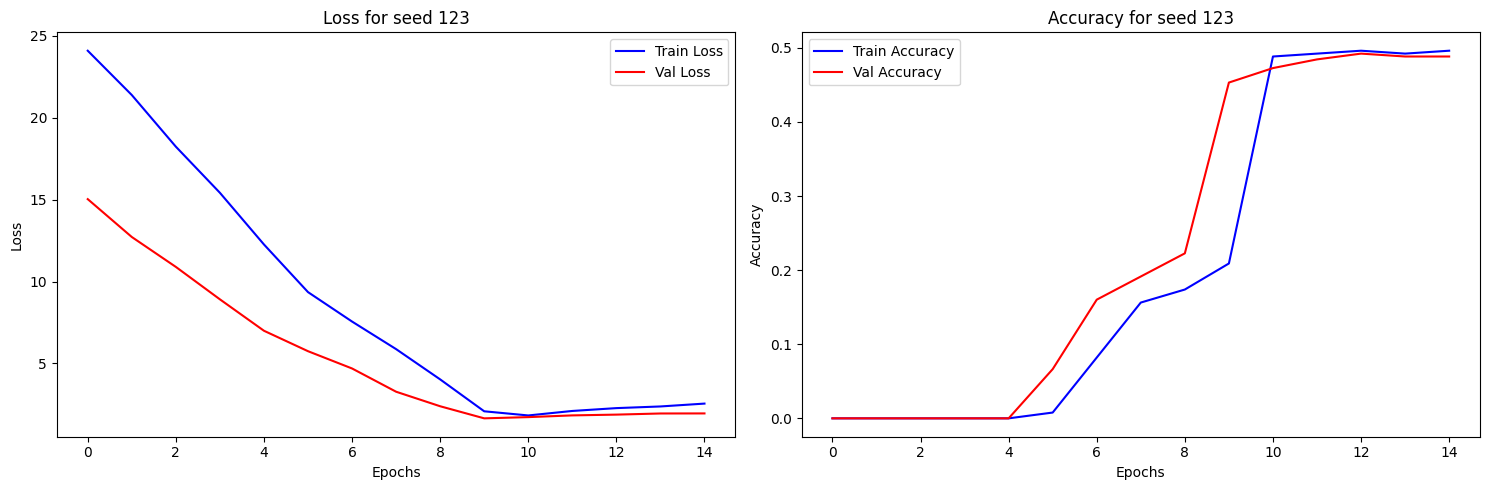

In [ ]:
# Plot the results
train_accuracy = results_ri['123']['train_accuracy']
val_accuracy = results_ri['123']['val_accuracy']
train_loss = results_ri['123']['train_loss']
val_loss = results_ri['123']['val_loss']
epochs = range(1, len(train_loss) + 1)
#Subplots: one with loss curve one with accuracy curves
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].plot(train_loss, 'b-', label='Train Loss')
axes[0].plot(val_loss, 'r-', label='Val Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].set_title(f"Loss for seed {123}")
axes[1].plot(train_accuracy, 'b-', label='Train Accuracy')
axes[1].plot(val_accuracy, 'r-', label='Val Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].set_title(f"Accuracy for seed {123}")
plt.tight_layout()
plt.show()


#### Assessing performance on rotated data

In [ ]:
# Load ModelNet10 dataset
# transform = T.SamplePoints(1024)
from torch_geometric.transforms import Compose, FaceToEdge
def add_node_attribute_pos_rotate(data):
    #Random angle
    angle = torch.rand(1)
    pos = data.pos
    #Rotate each node by angle
    pos_rotated = rotate_matrix(pos,angle)
    data.x = pos_rotated
    return data
pre_transform = Compose((add_node_attribute_pos,FaceToEdge(remove_faces=True)))
mesh_dataset_2_3_3 = ModelNet(root='...', name='10',transform=pre_transform) #, transform=transform)
# Exploring the dataset
print(f"Dataset size: {len(mesh_dataset_2_3_2)}")
print(f"Number of classes: {mesh_dataset_2_3_2.num_classes}")
print(f"Example data point: {mesh_dataset_2_3_2[0]}")

Dataset size: 3991
Number of classes: 10
Example data point: Data(pos=[3456, 3], y=[1], x=[3456, 3], edge_index=[2, 17712])


In [ ]:
DATA_PERTURB_SEEDS = [123]  # 3 distinct seeds for data perturbations
train_size = 512
val_size = 256
test_size = 256
batch_size = 256
learning_rate = 0.001
weight_decay = 0.001
scheduler = True
schedule_patience = 20
epochs = 15
results_ri = {}
device = 'cpu'

for perturb_seed in DATA_PERTURB_SEEDS:

    # Set seed
    torch.manual_seed(perturb_seed)

    # Split dataset into train and test
    dataset = mesh_dataset_2_3_3[:train_size + val_size + test_size]
    train_dataset, val_loader, test_dataset = random_split(dataset, [train_size, val_size,test_size])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Instantiate training wrapper
    model = SimpleGCN_Rotationally_Invariant(3, layer_configs, 10)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    train_loss_for_epoch = []
    test_loss_for_epoch = []
    train_accuracies_for_epoch = []
    test_accuracies_for_epoch = []

    for epoch in range(epochs):
        total_train_loss = 0
        total_test_loss = 0
        total_train_accuracy = 0
        total_test_accuracy = 0
        for batch in train_loader:
            optimizer.zero_grad()
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            loss = F.cross_entropy(out, batch.y)
            total_train_loss += loss.item()
            predicted_tags = np.argmax(out.detach().numpy(),axis=1)
            total_train_accuracy += accuracy_score(batch.y.detach().numpy(), predicted_tags)
            loss.backward()
            optimizer.step()
        for batch in val_loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            loss = F.cross_entropy(out, batch.y)
            total_test_loss += loss.item()
            predicted_tags = np.argmax(out.detach().numpy(),axis=1)
            total_test_accuracy= accuracy_score(batch.y, predicted_tags)
        train_loss_for_epoch.append(total_train_loss/len(train_loader))
        test_loss_for_epoch.append(total_test_loss/len(val_loader))
        train_accuracies_for_epoch.append(total_train_accuracy/len(train_loader))
        test_accuracies_for_epoch.append(total_test_accuracy/len(val_loader))

        print("Epoch: {}, Train Loss: {}, Val Loss: {}, Train Accuracy: {}, Val Accuracy: {}".format(epoch, total_train_loss/len(train_loader), total_test_loss/len(val_loader), total_train_accuracy/len(train_loader), total_test_accuracy/len(val_loader)))

    # Save the results
    key = f"{perturb_seed}"

    results_ri[key] = {
        "train_loss": train_loss_for_epoch,
        "train_accuracy": train_accuracies_for_epoch,
        "val_loss": test_loss_for_epoch,
        "val_accuracy": test_accuracies_for_epoch,
      }


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Train Loss: 24.087170600891113, Val Loss: 15.02957534790039, Train Accuracy: 0.0, Val Accuracy: 0.0
Epoch: 1, Train Loss: 21.38338279724121, Val Loss: 12.719103813171387, Train Accuracy: 0.0, Val Accuracy: 0.0
Epoch: 2, Train Loss: 18.23161220550537, Val Loss: 10.893660545349121, Train Accuracy: 0.0, Val Accuracy: 0.0
Epoch: 3, Train Loss: 15.417275428771973, Val Loss: 8.914562225341797, Train Accuracy: 0.0, Val Accuracy: 0.0
Epoch: 4, Train Loss: 12.262739181518555, Val Loss: 6.9971723556518555, Train Accuracy: 0.0, Val Accuracy: 0.0
Epoch: 5, Train Loss: 9.35531997680664, Val Loss: 5.749187469482422, Train Accuracy: 0.0078125, Val Accuracy: 0.06640625
Epoch: 6, Train Loss: 7.558105945587158, Val Loss: 4.694565296173096, Train Accuracy: 0.08203125, Val Accuracy: 0.16015625
Epoch: 7, Train Loss: 5.876155853271484, Val Loss: 3.2758607864379883, Train Accuracy: 0.15625, Val Accuracy: 0.19140625
Epoch: 8, Train Loss: 4.0288543701171875, Val Loss: 2.389180898666382, Train Accurac

In [ ]:
#Get test accuracy
total_test_accuracy = 0
for batch in test_loader:
    batch = batch.to(device)
    out = model(batch.x, batch.edge_index, batch.batch)
    predicted_tags = np.argmax(model(batch.x, batch.edge_index, batch.batch).detach().numpy(),axis=1)
    total_test_accuracy += accuracy_score(batch.y.detach().numpy(), predicted_tags)
print("Test Accuracy: {}".format(total_test_accuracy/len(test_loader)))


Test Accuracy: 0.52734375


The test accuracy is the same as the non-rotated dataset. This proves rotational  invariance of the data

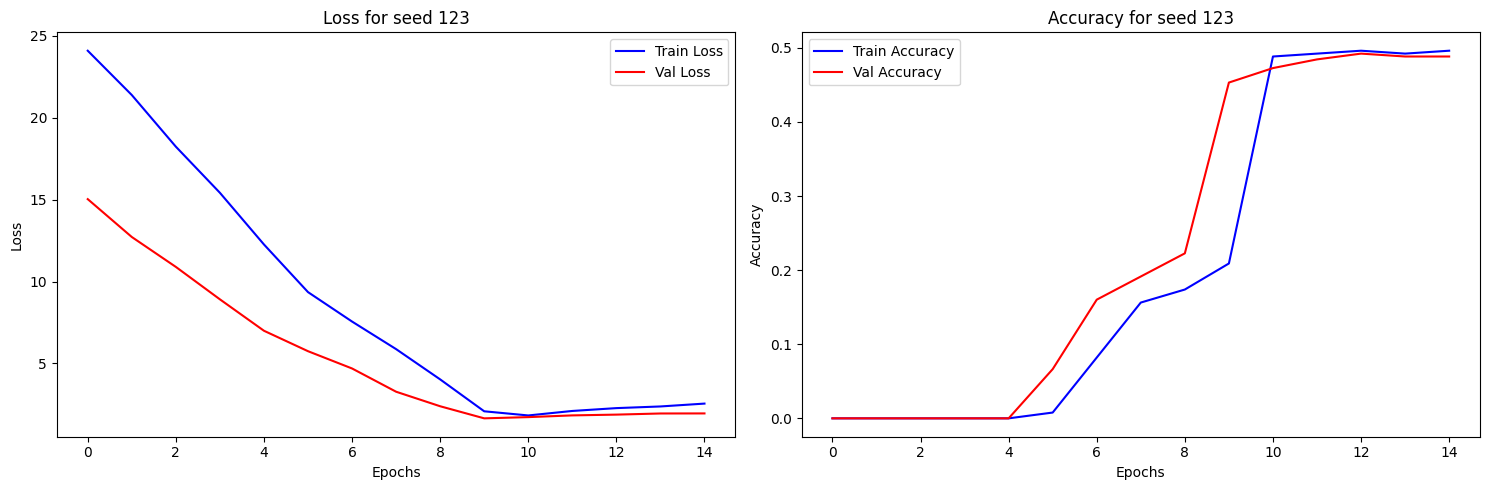

In [ ]:
# Plot the results
train_accuracy = results_ri['123']['train_accuracy']
val_accuracy = results_ri['123']['val_accuracy']
train_loss = results_ri['123']['train_loss']
val_loss = results_ri['123']['val_loss']
epochs = range(1, len(train_loss) + 1)
#Subplots: one with loss curve one with accuracy curves
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].plot(train_loss, 'b-', label='Train Loss')
axes[0].plot(val_loss, 'r-', label='Val Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].set_title(f"Loss for seed {123}")
axes[1].plot(train_accuracy, 'b-', label='Train Accuracy')
axes[1].plot(val_accuracy, 'r-', label='Val Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].set_title(f"Accuracy for seed {123}")
plt.tight_layout()
plt.show()


Clearly, the performance on both the normal dataset and the randomly rotated dataset are identically - demonstrating how using relational distances between points is rotationally invariant